In [1]:
#### SEQUENCING DEPTH NORMALIZATIONS 
# CPM  ### DONE! ###
# RPKM
# TPM

#### SEQUENCING DEPTH + DISTRIBUTION NORMALIZATION 
### QUANTILE (DONE!) ###

#### SEQUENCING DEPTH + COMPOSITION BIASES NORMALIZATIONS
# TMM (EdgeR) ### check if scaling factors match with edgeR , otherwise ### DONE! ### 
# RLE (DESeq2) 
# MRN 

# READ-IN COUNT DATA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math 
%matplotlib inline

df_counts = pd.read_csv("count_mESC-NPC48h.tsv", sep="\t", header=0, index_col=0)
#df_counts.columns = ["Ctr_{}".format(i) for i in range(1,6)] + ["Dot1lcKO_{}".format(i) for i in range(1,6)]
### Here we induce an offset in the data 
#df_counts["Dot1lcKO_1"] = df_counts["Dot1lcKO_1"] * 2
print(df_counts.shape)
df_counts.head()


(54146, 6)


,mESC_DMSO_rep1,mESC_DMSO_rep2,mESC_DMSO_rep3,2_NPC_DMSO,4_NPC_DMSO,5_NPC_DMSO
ENSMUSG00000000001.4,20110,12401,17546,14824,14854,12540
ENSMUSG00000000003.15,0,0,0,0,0,0
ENSMUSG00000000028.15,4601,3898,3437,1228,1764,853
ENSMUSG00000000031.16,54215,39027,54531,37673,37950,6254
ENSMUSG00000000037.16,739,375,1004,497,275,114


# Filtering functions

Here we define some functions that are usefull to filter out lowly expressed genes.

In [2]:
def filter_counts(df_counts, rowsum = 0):
    
    '''
    Filters out genes whose rowsum is less or equal to a user defined threshold.
    By defalut, the function filters out genes that have zero reads aligned to them across all samples.
    '''
    
    df_filtered = df_counts.loc[df_counts.sum(axis=1) > rowsum]
    
    return df_filtered

In [3]:
df_filt = filter_counts(df_counts)
print(df_filt.shape)
df_filt.head()

(35450, 6)


,mESC_DMSO_rep1,mESC_DMSO_rep2,mESC_DMSO_rep3,2_NPC_DMSO,4_NPC_DMSO,5_NPC_DMSO
ENSMUSG00000000001.4,20110,12401,17546,14824,14854,12540
ENSMUSG00000000028.15,4601,3898,3437,1228,1764,853
ENSMUSG00000000031.16,54215,39027,54531,37673,37950,6254
ENSMUSG00000000037.16,739,375,1004,497,275,114
ENSMUSG00000000049.11,1,1,0,2,5,3


In [4]:
def filter_CPM(df_counts, min_cpm = 1, min_nSamples = 2):
    
    '''
    Retains genes whose CPM is more than a user defined threshold (default 1 - EdgeR default) 
    in at least n samples (user defined, default 2 - EdgeR default)
    
    NOTE: CPM varies with sequencing depth. To define a sensible threshold, it is recommended to study the 
    CPM distribution.
    '''
    
    df_cpm = (df_counts / df_counts.sum()) * 1000000
    
    keep = (df_cpm > min_cpm).sum(axis=1) >= min_nSamples
    
    return df_counts.loc[keep]

In [5]:
df_filt_CPM = filter_CPM(df_counts)
print(df_filt_CPM.shape)
df_filt_CPM.head()

(15991, 6)


,mESC_DMSO_rep1,mESC_DMSO_rep2,mESC_DMSO_rep3,2_NPC_DMSO,4_NPC_DMSO,5_NPC_DMSO
ENSMUSG00000000001.4,20110,12401,17546,14824,14854,12540
ENSMUSG00000000028.15,4601,3898,3437,1228,1764,853
ENSMUSG00000000031.16,54215,39027,54531,37673,37950,6254
ENSMUSG00000000037.16,739,375,1004,497,275,114
ENSMUSG00000000056.7,1340,1293,1189,9138,7905,10178


In [6]:
def MAplot_dens(df_exp, col1,col2):

    s1 = np.log2(df_exp[col1])
    s2 = np.log2(df_exp[col2])
    
    M = s1 - s2
    A = (s1 + s2) / 2 
    
    A_plot = A.replace([np.inf, -np.inf], np.nan).dropna()
    M_plot = M.replace([np.inf, -np.inf], np.nan).dropna()
    
    fig, ax = plt.subplots(2,2, dpi=200, gridspec_kw = {'height_ratios':[1, 5], 'width_ratios':[5, 1]})
    plt.subplots_adjust(hspace = 0.05, wspace = 0.03)
    
    n, x = np.histogram(A_plot, bins=np.linspace(min(A_plot), max(A_plot), 100), 
                   density=True)  
    
    n_M, x_M = np.histogram(M_plot, bins=np.linspace(min(M_plot), max(M_plot), 100), 
                   density=True)  
    
    density = stats.gaussian_kde(A_plot)
    density_M = stats.gaussian_kde(M_plot)
    
    ax[0][0].axis('off')
    ax[0][1].axis('off')
    ax[1][1].axis('off')

    ax[0][0].fill_between(np.linspace(min(A_plot), max(A_plot), 100),density(x), color="k", alpha=0.5)
    ax[1][1].fill_between(density_M(x_M), np.linspace(min(M_plot), max(M_plot), 100), color="k", alpha=0.5)
    ax[1][1].axhline(0, color='red', linestyle="-")
    ax[1][1].set_ylim((-5.9,5.9))

    ax[1][0].scatter(A_plot,M_plot, s=7, color="k", marker="o", alpha=0.3)
    ax[1][0].axhline(0, color='red',linestyle="-")
    ax[1][0].set_ylabel("M", rotation=0)
    ax[1][0].set_xlabel("A", rotation=0)
    ax[1][0].set_ylim((-5.9,5.9))
    for j,z in zip(M_plot,A_plot):
        if j > 5.9:
            ax[1][0].scatter(z,5.8, s=7,marker="^",color='red', alpha=0.5)
        elif j < -5.9:
            ax[1][0].scatter(z,-5.8, s=7,marker="v",color='red', alpha=0.5)
    
    
    return None

/Users/ferrari/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ferrari/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.


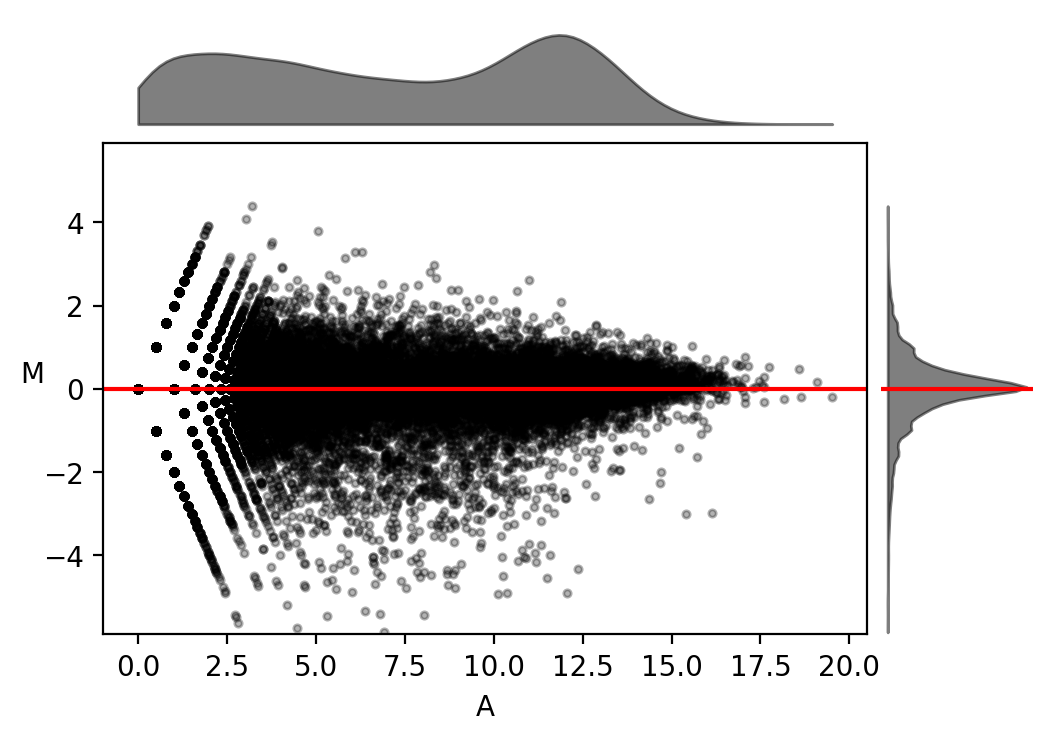

In [15]:
MAplot_dens(df_counts, list(df_counts)[3],list(df_counts)[4])

# COUNT PER MILLION (CPM)


In [7]:
def CPM(df_counts):
    
    return (df_counts / df_counts.sum()) * 1000000


In [8]:
CPM(df_filt).sum()

mESC_DMSO_rep1    1000000.0
mESC_DMSO_rep2    1000000.0
mESC_DMSO_rep3    1000000.0
2_NPC_DMSO        1000000.0
4_NPC_DMSO        1000000.0
5_NPC_DMSO        1000000.0
dtype: float64

# QUANTILE NORMALIZATION

To perform a quantile normalization, follow these steps (from https://www.youtube.com/watch?v=ecjN6Xpv6SE):

1) For each experiment, order the gene expression and the associate genes from highest to lowest.
  
2) Then, starting from the top, consider the expression value of the most expressed gene in each dataset. Assign to these genes the average expression of the top expressed genes. Then repeat this procedure for the genes that have rank II, III, and so on down to the bottom.


In [625]:
def quantile_norm(df_counts):
    
    ''' 
    Function to compute quantile normalization of count expression data. 
    input: counts dataframe (genes as rows (index) and samples as columns)
    putput: quantile normalized gene expression (index sorted)
    '''
    
    df_counts = filter_counts(df_counts)
    
    dixio_in={}
    for i in list(df_counts):
        dixio_in[i] = [list(df_counts[i].sort_values(ascending =False)),list(df_counts[i].sort_values(ascending =False).index)]
    
    dixio_norm={}
    for k in list(dixio_in):
        dixio_norm[k]=[[], dixio_in[k][1]]
    for j in range(len(dixio_in[list(dixio_in)[0]][0])):
        prov_list=[]
        for k in dixio_in:
            prov_list.append(dixio_in[k][0][j])
        for k in dixio_norm:
            dixio_norm[k][0].append(np.mean(prov_list))
    
    df_quant_norm = pd.DataFrame()
    for k in dixio_norm:
        df_quant_norm[k] = pd.Series(dixio_norm[k][0], index = dixio_norm[k][1]).sort_index()
    
    return df_quant_norm
    

This form of normalization is called "quantile" normalization because the quantiles of the normalized expression of each sample are exactly the same. 

Hereunder is a proof of it. We show how the qq-plot looks like when comparing the distribution of two samples before and after quantile normalization. You can appreciate that the qq-plot of the normalized expression lays precisely on the $x=y$ line

In [626]:
df_quant = quantile_norm(df_filt)
df_quant.head()

,Ctr_1,Ctr_2,Ctr_3,Ctr_4,Ctr_5,Dot1lcKO_1,Dot1lcKO_2,Dot1lcKO_3,Dot1lcKO_4,Dot1lcKO_5
ENSMUSG00000000001.4,16856.4,15955.8,15926.8,14563.8,13836.7,17359.5,19054.1,16900.0,13248.0,13516.9
ENSMUSG00000000028.15,2729.5,2754.9,2651.4,2692.5,2214.3,1975.8,2550.1,2257.3,2181.7,1980.3
ENSMUSG00000000031.16,4455.6,3564.9,7642.6,3707.9,6364.4,7498.0,4102.4,4334.0,3765.2,7420.8
ENSMUSG00000000037.16,503.8,385.6,386.5,428.2,467.6,402.3,316.5,313.2,408.1,419.7
ENSMUSG00000000049.11,2.1,3.1,6.6,0.7,2.4,0.0,1.9,2.8,1.1,1.2


/Users/ferrari/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ferrari/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.


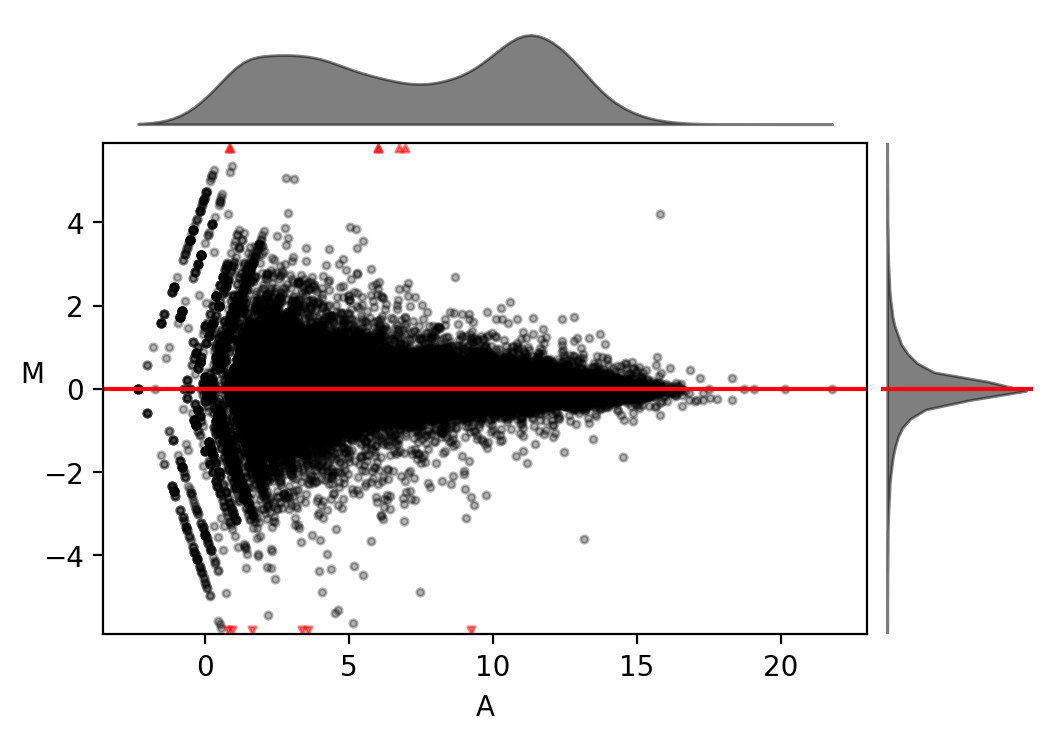

In [627]:
MAplot_dens(df_quant, "Dot1lcKO_1","Ctr_1")

In [628]:
# Here we check whether we successfully normalized for sequencing depth
df_quant.sum()

Ctr_1         6.485337e+07
Ctr_2         6.485337e+07
Ctr_3         6.485337e+07
Ctr_4         6.485337e+07
Ctr_5         6.485337e+07
Dot1lcKO_1    6.485337e+07
Dot1lcKO_2    6.485337e+07
Dot1lcKO_3    6.485337e+07
Dot1lcKO_4    6.485337e+07
Dot1lcKO_5    6.485337e+07
dtype: float64

In [757]:
qq_counts = df_counts.quantile(np.arange(0,1,0.01),axis=0)
qq_norm = df_quant.quantile(np.arange(0,1,0.01),axis=0)
qq_norm.head(n=20)

,Ctr_1,Ctr_2,Ctr_3,Ctr_4,Ctr_5,Dot1lcKO_1,Dot1lcKO_2,Dot1lcKO_3,Dot1lcKO_4,Dot1lcKO_5
0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
0.01,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
0.02,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
0.03,0.200,0.200,0.200,0.200,0.200,0.200,0.200,0.200,0.200,0.200
0.04,0.600,0.600,0.600,0.600,0.600,0.600,0.600,0.600,0.600,0.600
0.05,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.900
0.06,1.100,1.100,1.100,1.100,1.100,1.100,1.100,1.100,1.100,1.100
0.07,1.100,1.100,1.100,1.100,1.100,1.100,1.100,1.100,1.100,1.100
0.08,1.300,1.300,1.300,1.300,1.300,1.300,1.300,1.300,1.300,1.300
0.09,1.700,1.700,1.700,1.700,1.700,1.700,1.700,1.700,1.700,1.700


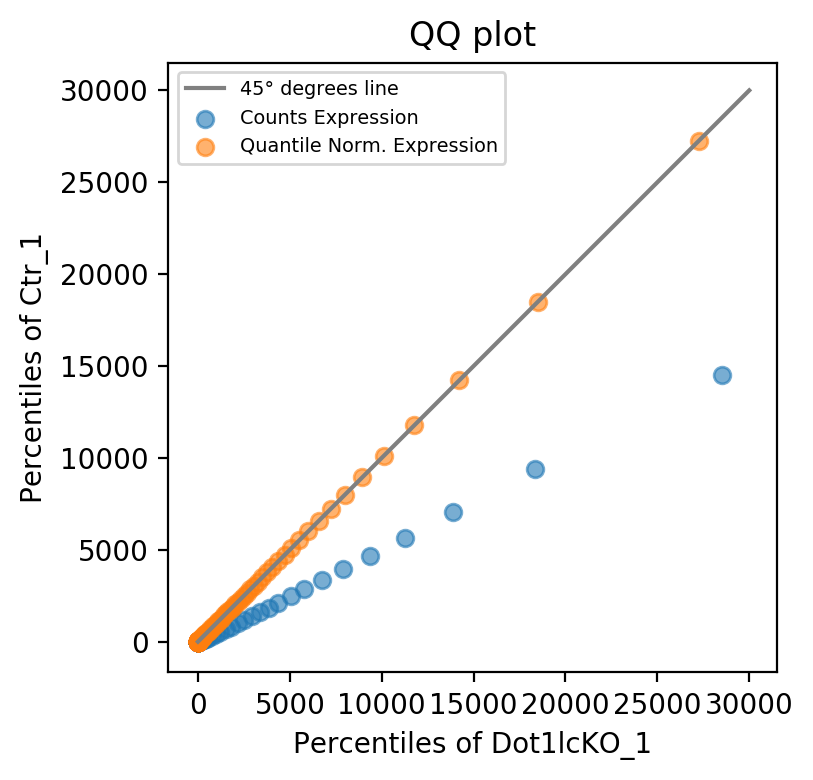

In [630]:
fig,ax = plt.subplots(dpi=200)
ax.set_aspect('equal', 'box')
plt.plot(range(30000),range(30000),color="gray", label = "45° degrees line")
s_1 = "Dot1lcKO_1"
s_2 = "Ctr_1"
ax.scatter(qq_counts[s_1], qq_counts[s_2],alpha=0.6, label = "Counts Expression")
ax.scatter(qq_norm[s_1], qq_norm[s_2],alpha=0.6, label = "Quantile Norm. Expression")
ax.set_xlabel("Percentiles of {}".format(s_1))
ax.set_ylabel("Percentiles of {}".format(s_2))
ax.legend(fontsize="x-small")
ax.set_title("QQ plot")
plt.tight_layout()

# Trimmed Mean of M-values (TMM) normalization (edgeR)

This is the normalization procedure used by EdgeR. To obtain it, you have to follow these steps (from https://www.youtube.com/watch?v=Wdt6jdi-NQo&t=618s):

1) Remove all untrinscribed genes (genes with 0 read counts in all samples) - This is good practice in general.

2) Pick one samples as the reference sample. This is the sample that we will use to normalize all other samples against. As reference, we choose the most "average" sample. To do that, we transform counts into CPM, take the 3rd quartile from each sample, average the 3rd quartile across all samples. Pick as reference the samples that has its 3rd quartile closest to the computed average.

3) Select the genes to calculate the scaling factors. This is done seperately for each sample relative to the reference sample. In edgeR, different genes are used in different samples to compute the scaling factors. 

4) Calculate the weighted average of the remaining log2 ratios

5) Get quasi-finalized scaling: 2^(w_average)

6) center scaling factors around 1


In [18]:
def TMM(df_counts, verbose=True):
    
    # 1. Filter out untrascribed genes
    df_counts_filt = filter_CPM(df_counts,1,2)
    
    # 2. Pick the reference sample
        ## Compute CPM
    df_cpm = CPM(df_counts_filt)
    lib_size = df_counts_filt.sum()
    
        ## identify samples whose 3rt quartile is closest to the mean of all samples 3rd quartile 
    ref = np.fabs(df_cpm.quantile(0.75,axis=0) - df_cpm.quantile(0.75,axis=0).mean()).idxmin()
    
    if verbose:
        print("reference sample : {}".format(ref))
    
    # 3. Select genes in each sample used to compute scaling factors
    dixio_MA = {}
    for i in list(df_counts):
        if i != ref:
            dixio_MA[i] = {}
            dixio_MA[i]["M"] = (np.log2(df_cpm[ref]) - np.log2(df_cpm[i])).replace([np.inf, -np.inf], np.nan).dropna()
            lista_M = dixio_MA[i]["M"].sort_values(ascending=False)
            n_30 = int(np.floor((len(lista_M) / 100) * 30))
            dixio_MA[i]["M"] = lista_M[n_30:len(lista_M)-n_30]
            
            dixio_MA[i]["A"] = ((np.log2(df_cpm[ref]) + np.log2(df_cpm[i]))/2).replace([np.inf, -np.inf], np.nan).dropna()
            lista_A = dixio_MA[i]["A"].sort_values(ascending=False)
            n_5 = int(np.floor((len(lista_A) / 100) * 5))
            dixio_MA[i]["A"] = lista_A[n_5:len(lista_A)-n_5]
            
            dixio_MA[i]["exp"] = df_cpm[i]
    
    # 4. isolate genes that have survived the trimming for both M and A
    for i in dixio_MA:
        idx = [j in dixio_MA[i]["A"].index for j in dixio_MA[i]["M"].index]
        idx_fin = dixio_MA[i]["M"].index[idx]
        dixio_MA[i]["M"] = dixio_MA[i]["M"].loc[idx_fin]
        dixio_MA[i]["A"] = dixio_MA[i]["A"].loc[idx_fin]
        dixio_MA[i]["exp"] = dixio_MA[i]["exp"].loc[idx_fin]
    
    # 5. compute the weighted average of the trimmed log2 ratios and transfort it back to normal number to 
    # get the row scaling factors
    for i in dixio_MA:  
        dixio_MA[i]["w_ave_log"] = (dixio_MA[i]["M"] * dixio_MA[i]["exp"]).sum() / dixio_MA[i]["exp"].sum()
        dixio_MA[i]["scale_factor"] = 2**(dixio_MA[i]["w_ave_log"])
    
    # 6. get raw scaling factors 
    scaling_fact = [1.0]
    samples = [ref]
    for i in dixio_MA:
        scaling_fact.append(dixio_MA[i]["scale_factor"])
        samples.append(i)
    row_scaling_fact = pd.Series(scaling_fact, index = samples)
    
    # 7. center row scaling factors around 1 and take their reciprocal to have the final scaling factors
    geom_mean = np.prod(scaling_fact)**(1/len(scaling_fact))
    final_scaling_fact = pd.Series([(k / geom_mean) for k in row_scaling_fact],index = samples).sort_index()     
    final_scaling_fact = final_scaling_fact**(-1)
    
    # 8. apply normalization factors to counts
    if sum([j in list(df_counts) for j in list(final_scaling_fact.index)]) == len(list(df_counts)):
        df_TMMnorm = df_counts.divide((final_scaling_fact*df_counts.sum()), axis="columns") * 1000000 
        libSize_SF = (final_scaling_fact*df_counts.sum()) / 1000000
        ### note : final_scaling_fact*df_counts.sum() is the EFFECTIVE LIBRARY SIZE ###
    
    return df_TMMnorm, final_scaling_fact, libSize_SF, lib_size
    

In [791]:
df_TMMnorm, scalfact, libSize_SF, lib_size = TMM(df_counts)
print(scalfact, lib_size)
#print(libSize_SF)
df_TMMnorm.head()


reference sample : Dot1lcKO_5


/Users/ferrari/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log2
/Users/ferrari/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2


Ctr_1         0.923987
Ctr_2         1.022523
Ctr_3         1.036314
Ctr_4         0.967359
Ctr_5         0.978690
Dot1lcKO_1    0.941920
Dot1lcKO_2    1.073534
Dot1lcKO_3    1.054019
Dot1lcKO_4    0.999822
Dot1lcKO_5    1.012363
dtype: float64 Ctr_1          54002396
Ctr_2          55614322
Ctr_3          64077355
Ctr_4          65838097
Ctr_5          62962434
Dot1lcKO_1    111624006
Dot1lcKO_2     53603897
Dot1lcKO_3     53961250
Dot1lcKO_4     65501617
Dot1lcKO_5     60125229
dtype: int64


,Ctr_1,Ctr_2,Ctr_3,Ctr_4,Ctr_5,Dot1lcKO_1,Dot1lcKO_2,Dot1lcKO_3,Dot1lcKO_4,Dot1lcKO_5
ENSMUSG00000000001.4,274.179184,261.695850,251.657537,225.277674,211.764628,262.434957,289.548521,262.925426,201.067733,203.611521
ENSMUSG00000000003.15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000028.15,43.218787,43.703734,41.872784,41.600817,34.465402,30.886985,38.192515,34.973662,33.630654,30.965475
ENSMUSG00000000031.16,71.371024,56.691992,119.110486,57.683123,98.650734,114.511550,61.746300,67.157152,57.554591,111.436367
ENSMUSG00000000037.16,7.283166,5.581441,6.041945,5.893710,7.093913,6.796276,4.578939,5.071444,6.293367,7.261887


### NOTE: TMM scaling factors do not take into account library sizes 
(In Papyro Comparison of TMM (edgeR), RLE (DESeq2), and MRN Normalization Methods for a Simple Two-Conditions-Without-Replicates RNA-Seq Experimental Design)

To get the saling factors to correct for library size, we multiply the scaling factors by the library size to get the **EFFECTIVE LIBRARY SIZE** and we perform a CPM normalization using the **effective libray size** instead of the original one.


/Users/ferrari/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ferrari/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.


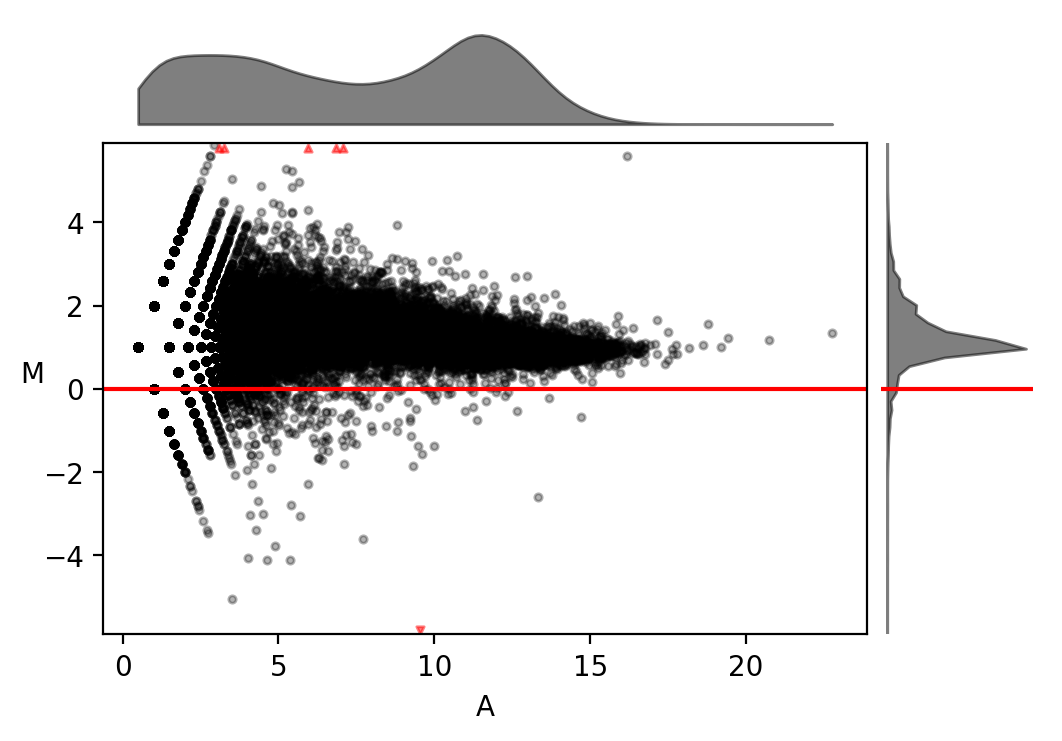

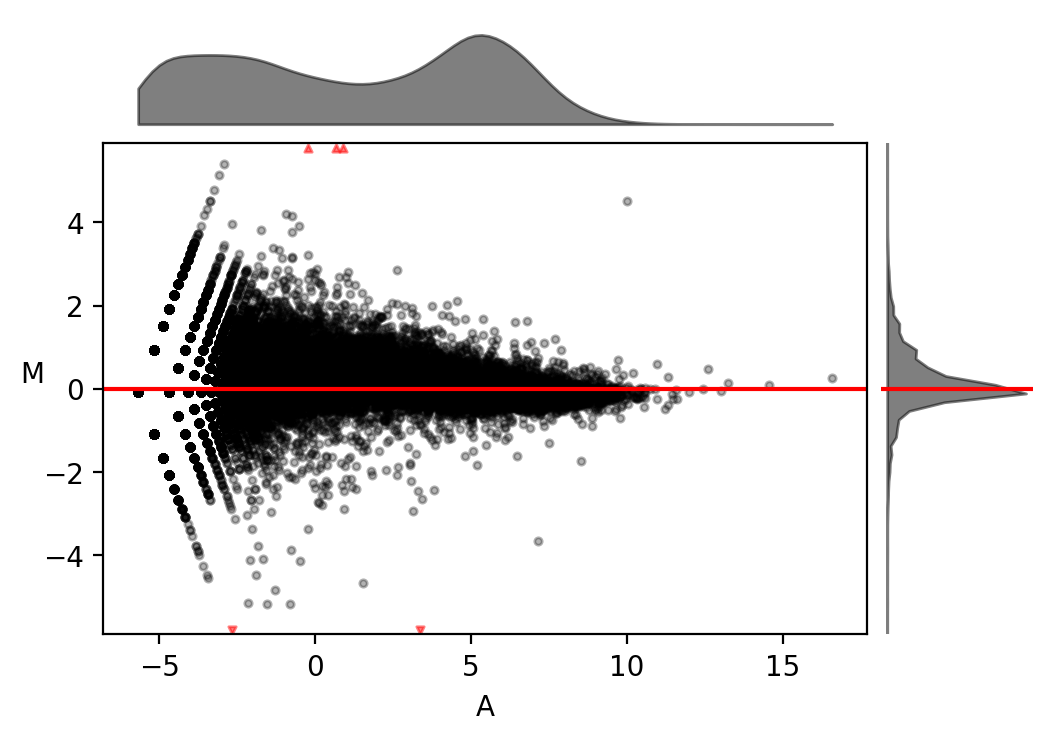

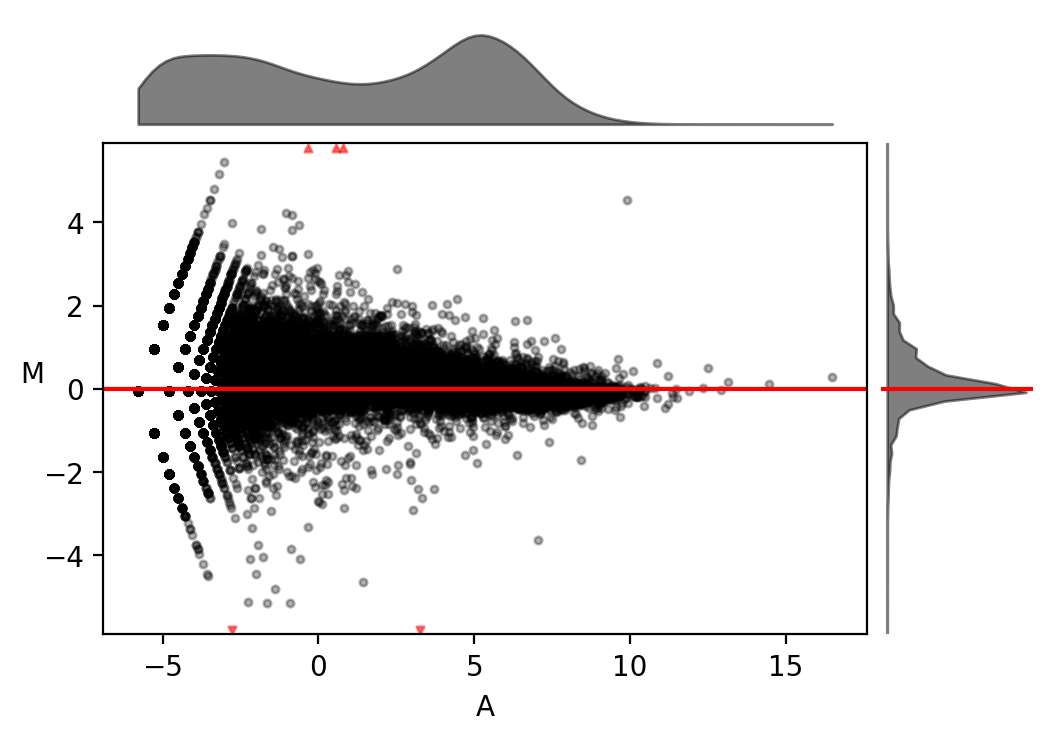

In [776]:
MAplot_dens(df_counts, "Dot1lcKO_1","Ctr_1")
MAplot_dens(df_TMMnorm, "Dot1lcKO_1","Ctr_1")
MAplot_dens((df_counts / df_counts.sum())*1000000, "Dot1lcKO_1","Ctr_1")  

# Relative Log Expression (RLE) normalization (DESeq2)



This is the method used by DESeq2 to normalize read counts across different samples for downstream DE analysis.
To perform RLE normalization, follow the following steps (from https://www.youtube.com/watch?v=UFB993xufUU) 

1) Filter out untranscribed genes;

2) Transform counts to the natural logarithm;

3) Compute the geometric mean of each gene across all samples;

4) Subtract the geometric mean from the log-transformed value of each gene;

5) Calculate the median of the ratios for each sample;

6) Convert the median from log space to normal number to get the scaling factors;

7) Divide the original read counts by the scaling factors.

In [9]:

def RLE(df_counts):
    
    ''' 
    This function performs RLE normalization implemented in DESeq2 
    (this function outputs the same scaling factors as computed by DESeq2::estimateSizeFactorsForMatrix()
    and applies them to the input counts dataframe, returning a RLE normalized expression table).
    input: pandas DataFrame with gene ID as index (rows names) and sample names as columns (column names)
    output: 1. scaling factors
            2. RLE normalized count DataFrame
    '''
    
    # 1. Filter out untrascribed genes
    df_counts_filt = filter_counts(df_counts)
    
    # 2. Take the ln of all values 
    df_log = np.log(df_counts_filt).replace([np.inf, -np.inf], np.nan).dropna()
    
    # 3. Compute the row-wise geometric average (geometric average of each gene expression across all samples)
    W_average = df_log.mean(axis = 1)
    
    # 4. Subtract the geometric mean from the log-transformed value of each gene
    df_sub = df_log.subtract(W_average, axis = "index")
    
    # 5. Calculate the median of the ratios for each sample
    median_ratios = df_sub.median(axis = 0)
    
    # 6. Convert the median from log space to normal number to get the scaling factors
    scaling_factors = math.e**(median_ratios)
    
    # 7. Divide the original read counts by the scaling factors
    df_norm = df_counts.divide(scaling_factors, axis = "columns")
    
    return scaling_factors, df_norm
    

In [711]:
sc_f , df_RLEnorm = RLE(df_counts)
sc_f

/Users/ferrari/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


Ctr_1         0.787126
Ctr_2         0.900691
Ctr_3         1.052281
Ctr_4         0.990940
Ctr_5         0.982958
Dot1lcKO_1    1.722498
Dot1lcKO_2    0.916936
Dot1lcKO_3    0.909044
Dot1lcKO_4    1.064520
Dot1lcKO_5    0.991168
dtype: float64

/Users/ferrari/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ferrari/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.


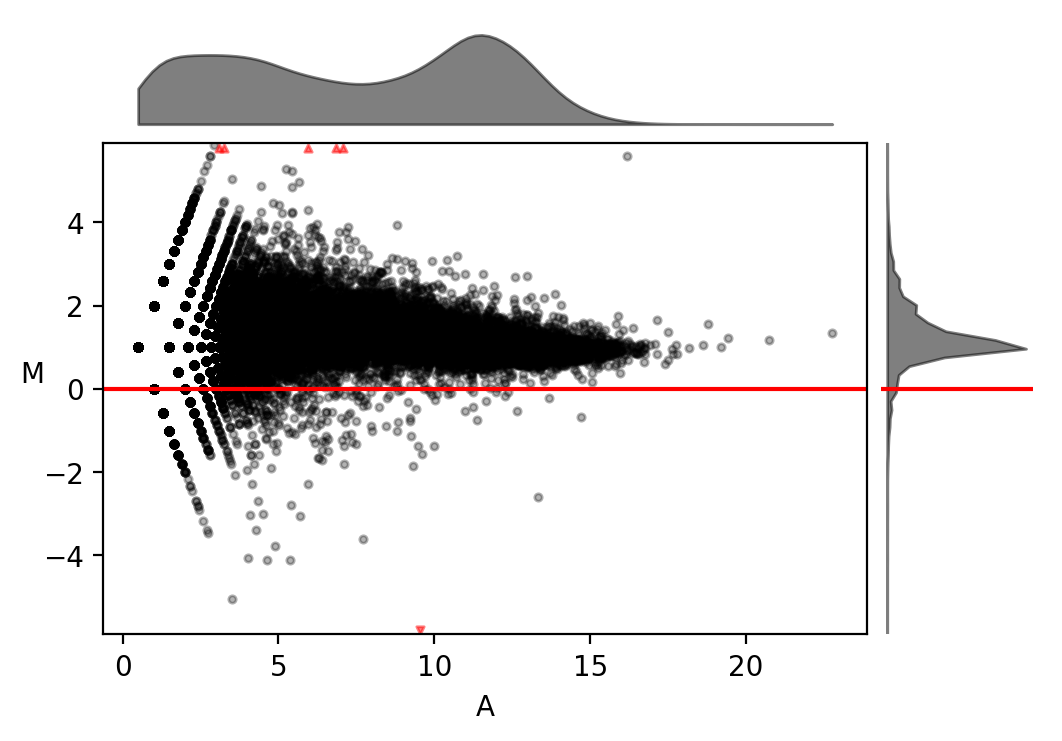

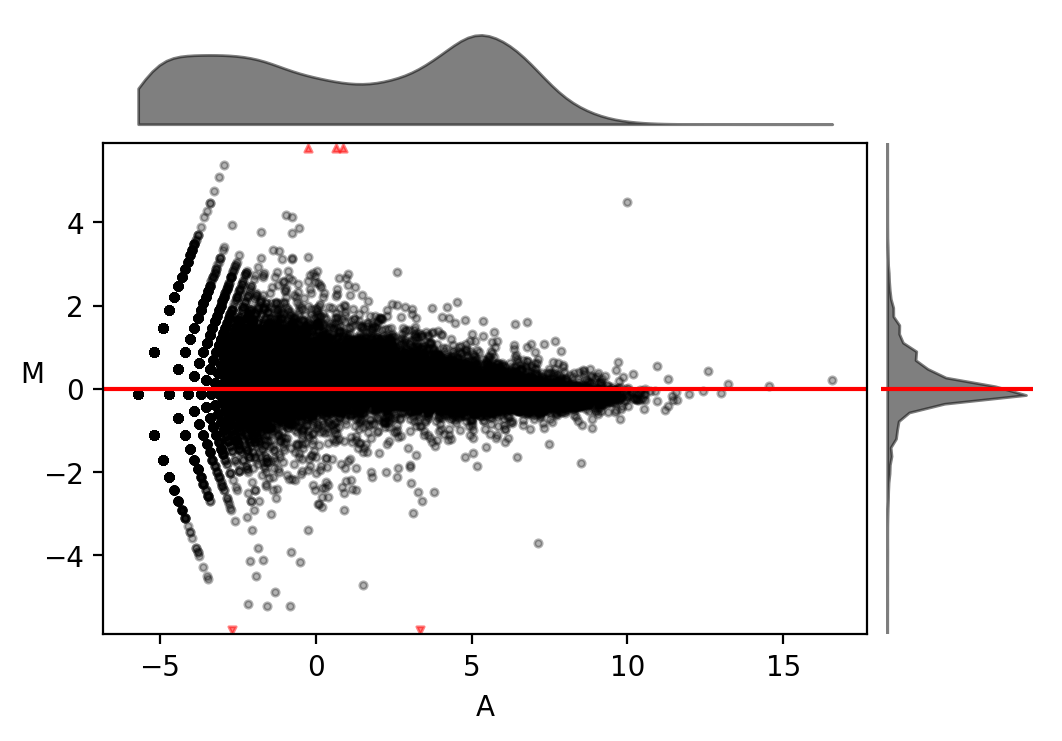

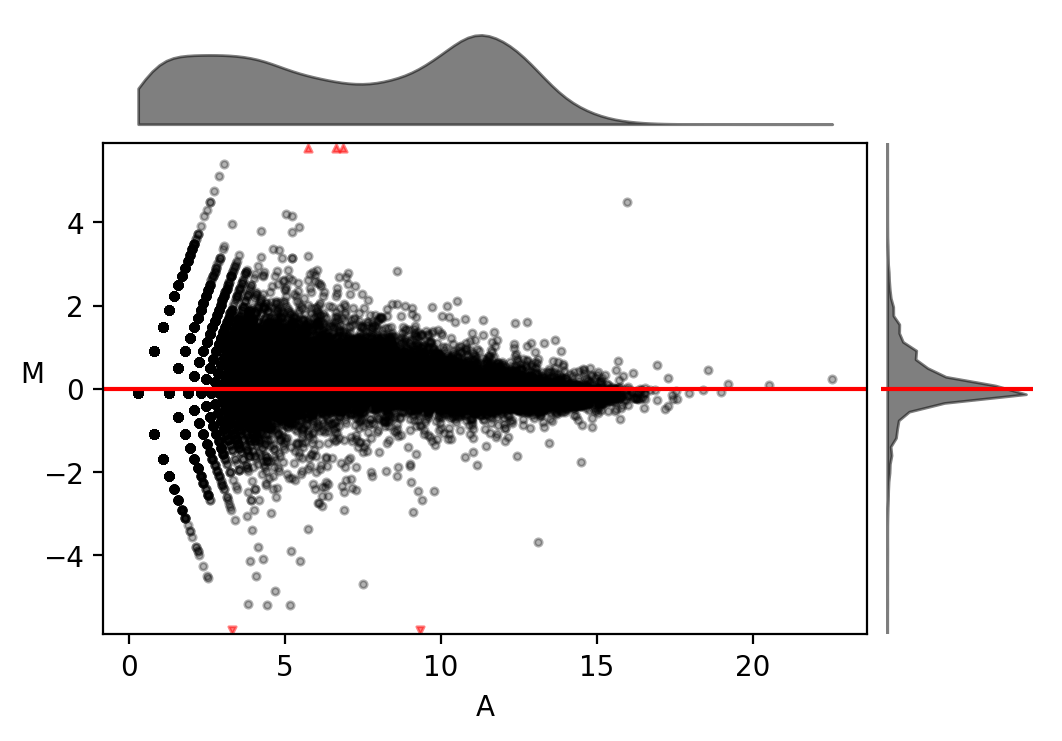

In [692]:
MAplot_dens(df_counts, "Dot1lcKO_1","Ctr_1")
MAplot_dens(df_TMMnorm, "Dot1lcKO_1","Ctr_1")
MAplot_dens(df_RLEnorm, "Dot1lcKO_1","Ctr_1")

In [10]:
sc_f, norm_c = RLE(df_counts)

/Users/ferrari/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


# Median Ratio Normalization (MRN)

In [11]:
sc_f

mESC_DMSO_rep1    1.293784
mESC_DMSO_rep2    0.966217
mESC_DMSO_rep3    1.059552
2_NPC_DMSO        1.003119
4_NPC_DMSO        1.025483
5_NPC_DMSO        0.768954
dtype: float64

In [12]:
norm_c.head()

,mESC_DMSO_rep1,mESC_DMSO_rep2,mESC_DMSO_rep3,2_NPC_DMSO,4_NPC_DMSO,5_NPC_DMSO
ENSMUSG00000000001.4,15543.554252,12834.597090,16559.822590,14777.912970,14484.887222,16307.874099
ENSMUSG00000000003.15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000028.15,3556.235361,4034.292352,3243.822538,1224.182213,1720.165683,1109.299570
ENSMUSG00000000031.16,41904.216499,40391.566861,51466.071223,37555.876640,37006.965806,8133.129555
ENSMUSG00000000037.16,571.192769,388.111758,947.569924,495.454853,268.166419,148.253401


In [13]:
import pymc3 as pm
import numpy as np
import scipy.stats as st

/Users/ferrari/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, mu]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:01<00:00, 2212.07draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,2592.786371,9.681969,0.153187,2573.579216,2611.122871,3067.737503,0.999503
alpha__0,0.993323,0.567235,0.011765,0.124218,2.076046,2265.729156,0.999604
alpha__1,0.438329,0.244731,0.005151,0.065654,0.929063,2126.087448,1.000645


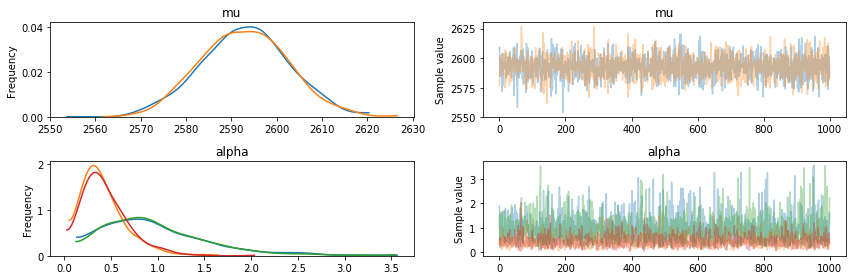

In [53]:
idx = 123
with pm.Model() as m1:
    
    mu = pm.Normal('mu', mu=norm_c.loc[norm_c.index[idx]].mean(), sd=10)
    alpha=pm.Exponential('alpha', lam=1,shape=2)
    
    count = pm.NegativeBinomial('count',mu=mu, alpha=alpha[[0,0,0,1,1,1]], observed=norm_c.loc[norm_c.index[idx]])
    
    trace_m1 = pm.sample(1000,tune=1000)
    
pm.traceplot(trace_m1)
pm.summary(trace_m1)

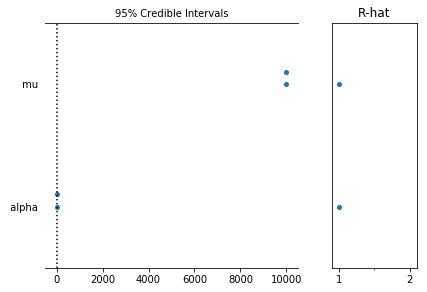

In [38]:
pm.forestplot(trace_m1)

In [54]:
norm_c.loc[norm_c.index[123]]

mESC_DMSO_rep1     3393.147845
mESC_DMSO_rep2    10362.066452
mESC_DMSO_rep3     1278.841879
2_NPC_DMSO          241.247635
4_NPC_DMSO          208.682231
5_NPC_DMSO           71.525764
Name: ENSMUSG00000000731.15, dtype: float64